In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split


# Use sample with size of 1M, 100K, 10K, 1K.
def use_sampled_dataset(size='1M'):
    try:
        metadata = pd.read_csv('2_fraud_metadata.csv')
    except:
        df_full = pd.read_csv('2_fraud_ex.csv')
        metadata = pd.DataFrame([df_full.shape], columns=['size', 'dim'])
        metadata.to_csv('2_fraud_metadata.csv', index=False)

    sample_map = {
        '1M': {
            'file_name': '2_fraud_1m.csv',
            'sample_ratio': 1000000 / metadata['size'][0],
        },
        '100K': {
            'file_name': '2_fraud_100k.csv',
            'sample_ratio': 100000 / metadata['size'][0],
        },
        '10K': {
            'file_name': '2_fraud_10k.csv',
            'sample_ratio': 10000 / metadata['size'][0],
        },
        '1K': {
            'file_name': '2_fraud_1k.csv',
            'sample_ratio': 1000 / metadata['size'][0],
        },
    }

    try:  # Use cached dataset if exists
        df = pd.read_csv(sample_map[size]['file_name'])
    except:  # Create dataset if not exists, using train_test_split with stratify on 'isFraud' field
        df_full = pd.read_csv('2_fraud_ex.csv')
        _, df = train_test_split(
            df_full, test_size=sample_map[size]['sample_ratio'], stratify=df_full['isFraud'])
        df.to_csv(sample_map[size]['file_name'], index=False)

    return df

# df = use_sampled_dataset('1M')

df = pd.read_csv('2_fraud_ex.csv')

# We'll use the entire dataset.
# If we use a sampled dataset, we lose the continuity of the time series data.

# Exploring the data...

In [116]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [117]:
# There's typo: Change column name from 'oldbalanceOrg' to 'oldbalanceOrig'
df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'}, inplace=True)

In [118]:
df.shape

(6362620, 11)

In [119]:
# step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
# type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
# amount - amount of the transaction in local currency.

# [Orig]
# nameOrig - customer who started the transaction
# oldbalanceOrig - initial balance before the transaction
# newbalanceOrig - new balance after the transaction.

# [Dest]
# nameDest - customer who is the recipient of the transaction
# oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).
# newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

# isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.
# isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrig  float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [120]:
# What are 'object' types?
print(type(df['type'][0]))
print(type(df['nameOrig'][0]))
print(type(df['nameDest'][0]))
# But all of these instances are strings...

<class 'str'>
<class 'str'>
<class 'str'>


## After inspecting each column, we can see that:
- `step` is said to be a unit of time, but it's encoded as integer. ***Maybe we need to give it a special treatment?***
- `type` is categorical (nominal), but it's encoded as string (object?).
- `nameOrig` and `nameDest` are encoded as string, but they're actually IDs.
- `isFraud` and `isFlaggedFraud` are encoded as integer, but they're actually boolean.

## Let's convert them:

In [121]:
df['type'] = df['type'].astype('category')

# nameOrig, nameDest are IDs. Should they be categorical?
# df['nameOrig'] = df['nameOrig'].astype('category')
# df['nameDest'] = df['nameDest'].astype('category')

df['isFraud'] = df['isFraud'].astype('bool')
df['isFlaggedFraud'] = df['isFlaggedFraud'].astype('bool')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int64   
 1   type            category
 2   amount          float64 
 3   nameOrig        object  
 4   oldbalanceOrig  float64 
 5   newbalanceOrig  float64 
 6   nameDest        object  
 7   oldbalanceDest  float64 
 8   newbalanceDest  float64 
 9   isFraud         bool    
 10  isFlaggedFraud  bool    
dtypes: bool(2), category(1), float64(5), int64(1), object(2)
memory usage: 406.5+ MB


In [122]:
df.describe()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08


In [123]:
df.isna().sum()  # No missing values in this dataset

# df.isna()
# df.isna().sum()
# df.isna().any(axis=1)
# df.isna().any(axis=0)

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [124]:
df.duplicated().sum()  # No duplicated rows

0

## No missing or duplicated values in the dataset:
- No further data processing/cleaning is needed

In [125]:
# Check for unique values
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrig    1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

## After inspecting the number of unique values in each column:
- The number of rows in the dataset is 6M, but the number of unique values for `nameDest` is 2.7M.
- There seems to be quite a few of repeated values in `nameDest`... We can suspect some '대포통장' (a.k.a. 'money mule') transactions later.

In [127]:
df[df['isFraud'] == True]

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,True,False
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,True,False
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.0,C972765878,0.00,0.00,True,False
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.0,C1007251739,26202.00,0.00,True,False
680,1,TRANSFER,20128.00,C137533655,20128.00,0.0,C1848415041,0.00,0.00,True,False
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,True,False
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,True,False
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,True,False
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,True,False


## In the above: Most of the fraud transactions are consecutive 'TRANSFER' and 'CASH_OUT' transactions!
### But, I don't know why the name of the consecutive transactions doesn't match...

# Quick (general) visualizations

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


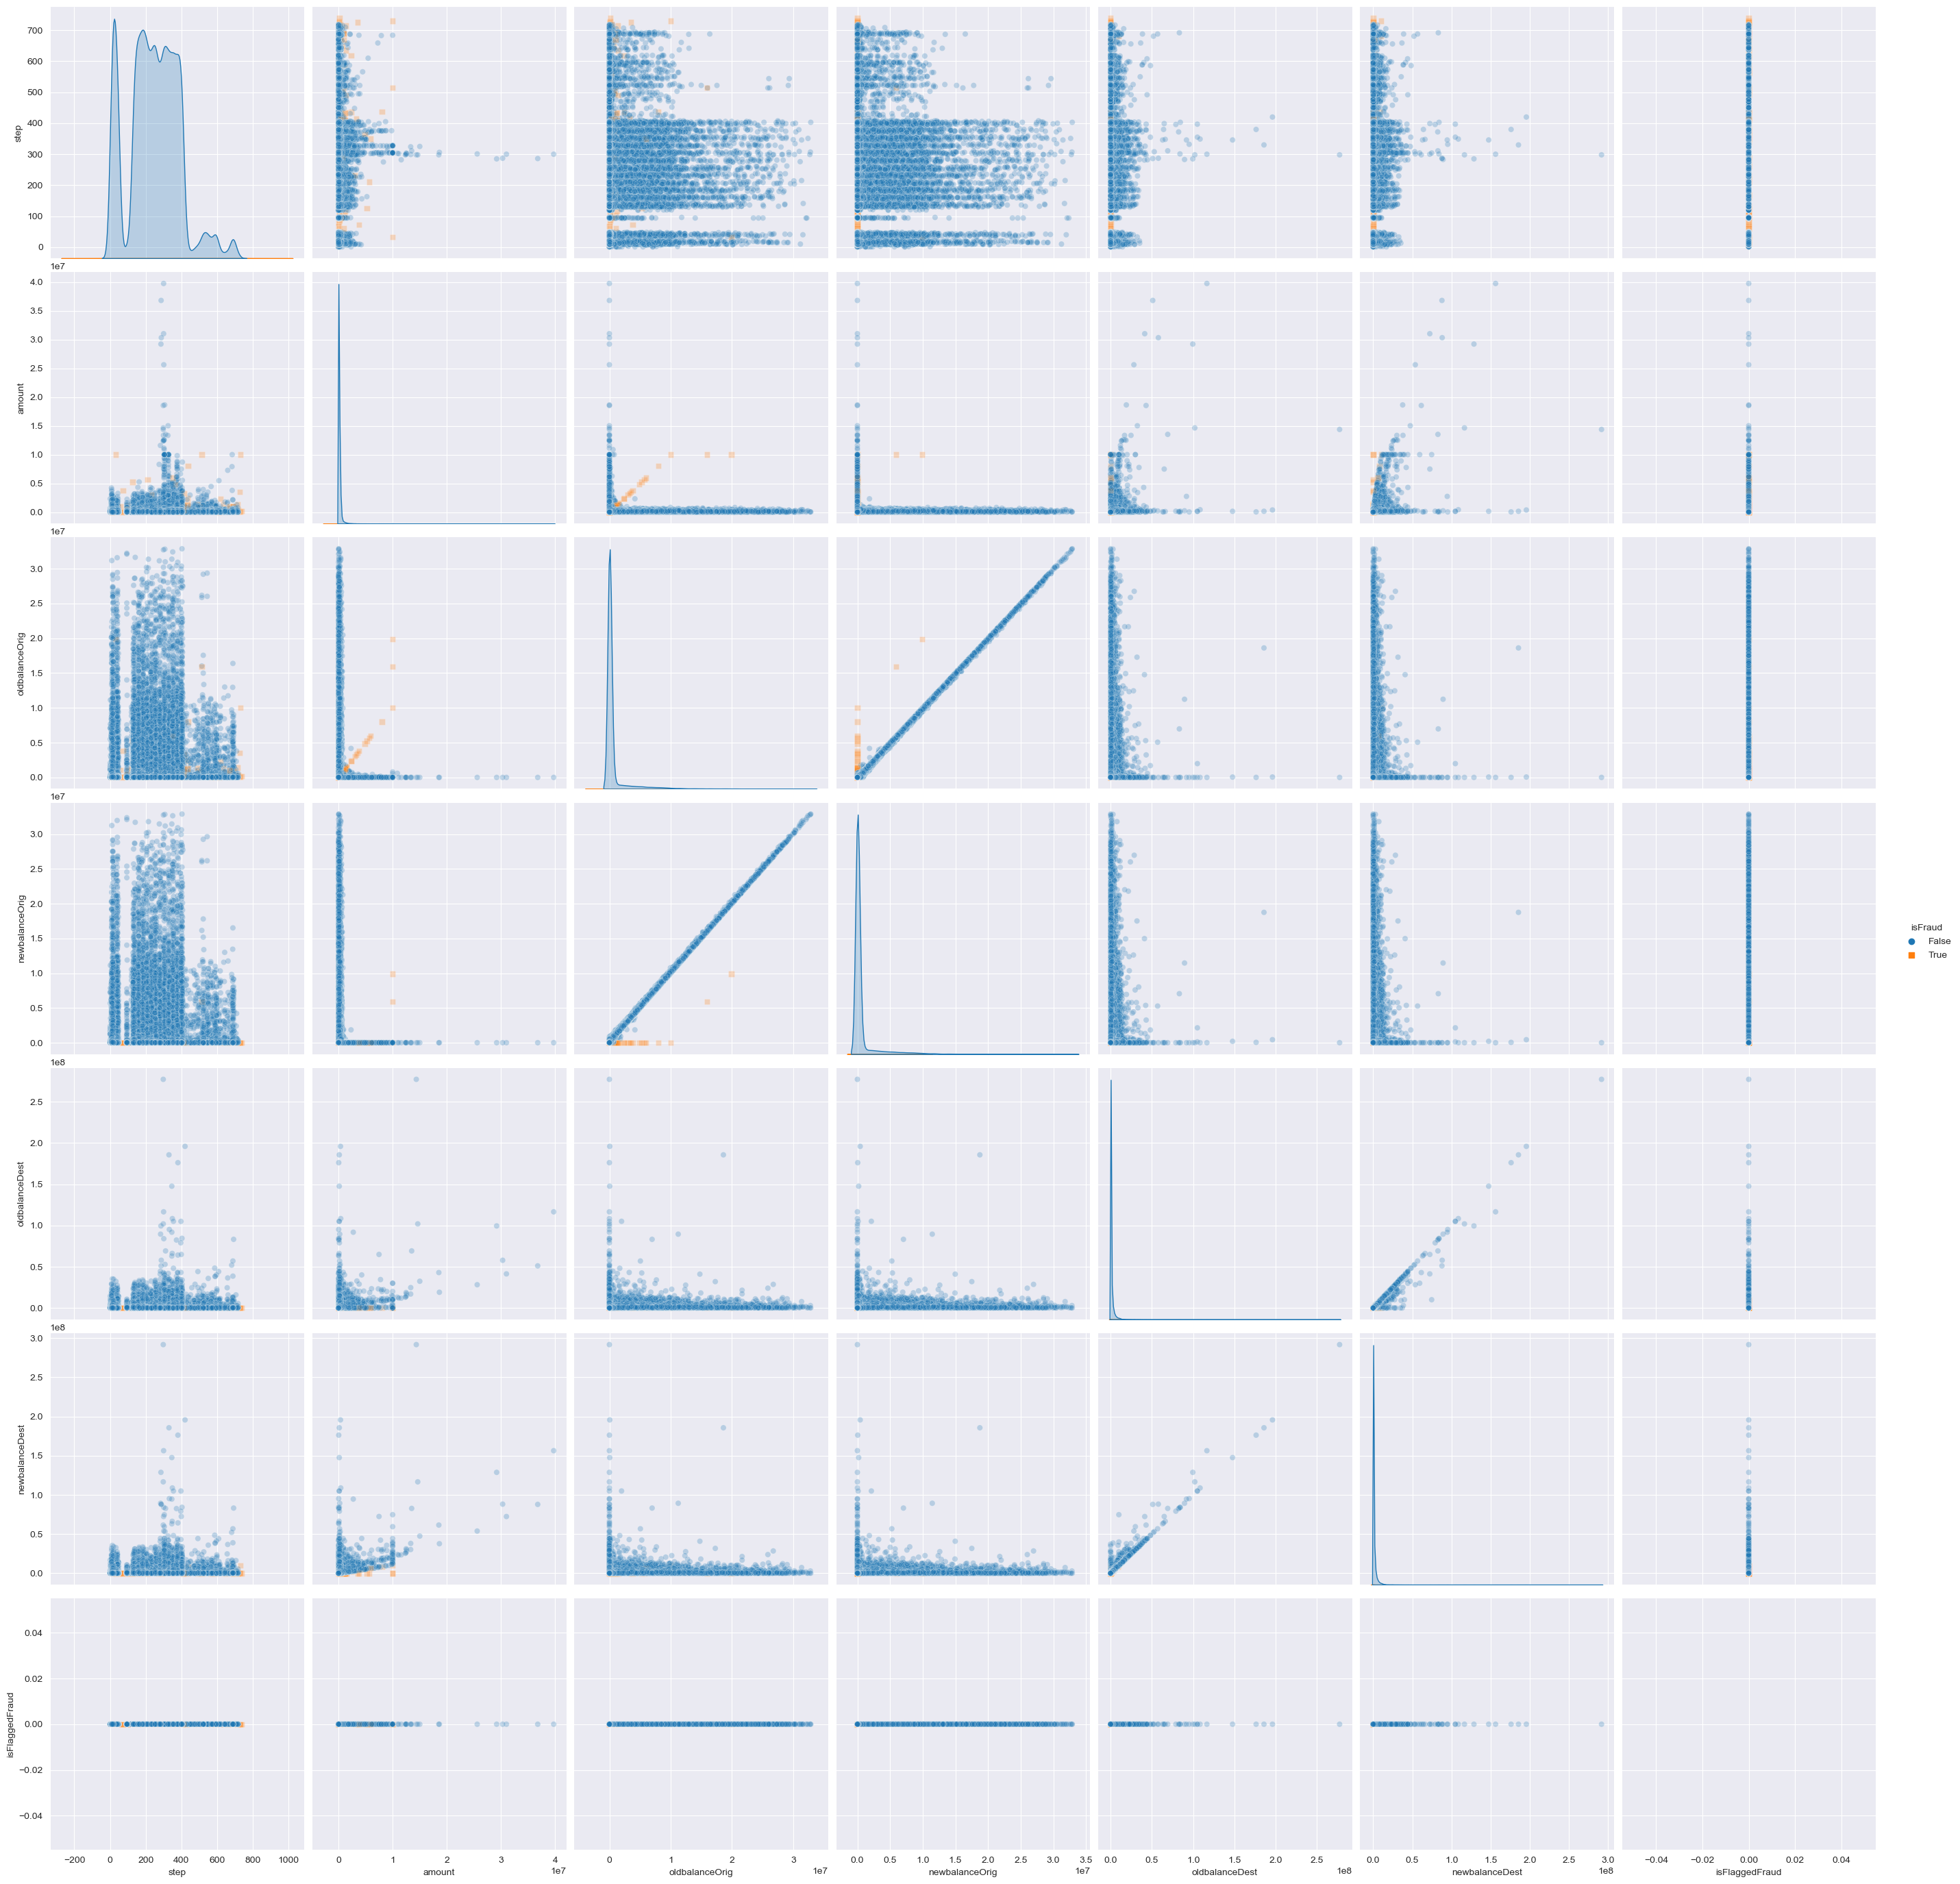

In [128]:
# pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(10, 10), diagonal='kde')

_, df_sampled = train_test_split(df, test_size=1 / 100, stratify=df['isFraud'])

sns.pairplot(data=df_sampled, hue='isFraud', markers=['o', 's'], plot_kws={'alpha': 0.25}, size=4)

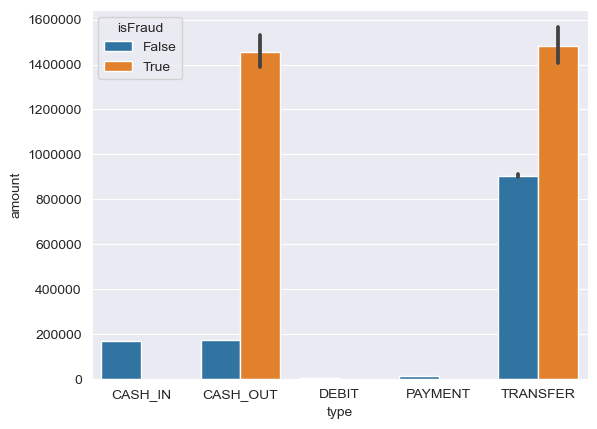

In [129]:
sns.barplot(x='type', y='amount', data=df, hue='isFraud')
plt.ticklabel_format(style='plain', axis='y', useOffset=False)
# Fraud transactions have a higher mean amount than non-fraud transactions.

# Creating new — and hopefully meaningful — features
> Maybe it's called "Feature Engineering"?

In [131]:
df_augmented = df.copy()

### Hypothesis 1: Merchandise transactions will be correlated with fraud transactions.
- Create a new column to indicate whether the transaction is for merchandise.

In [132]:
df_augmented['isMerchandise'] = df_augmented['nameDest'].str.contains('M')
df_augmented[['isFraud', 'isMerchandise']].groupby('isMerchandise').mean()

# No fraud transactions are for merchandise.
# Maybe merchants need to be verified before they can use the system?

,isFraud
isMerchandise,
False,0.00195
True,0.00000


In [133]:
df[['isFraud', 'amount']].groupby('isFraud').mean()
# Fraud transactions have a higher mean amount than non-fraud transactions.

,amount
isFraud,
False,1.781970e+05
True,1.467967e+06


## Suspicion for 'money mule' transactions.
### Hypothesis 2: The number of transactions for each `nameDest` and `nameOrig` will be correlated with fraud transactions. 
- Create a column for the number of transactions for each `nameDest`.
- Create a column for the number of transactions for each `nameOrig`.

In [134]:
df_augmented['numTransactionsForDest'] = df_augmented.groupby('nameDest')['nameDest'].transform('count')
df_augmented['numTransactionsForOrig'] = df_augmented.groupby('nameOrig')['nameOrig'].transform('count')

In [135]:
# Show correlation between 'numTransactionsForDest' and 'isFraud'
df_augmented[['isFraud', 'numTransactionsForDest']].corr()

,isFraud,numTransactionsForDest
isFraud,1.000000,-0.008982
numTransactionsForDest,-0.008982,1.000000


In [136]:
# Show correlation between 'numTransactionsForOrig' and 'isFraud'
df_augmented[['isFraud', 'numTransactionsForOrig']].corr()

,isFraud,numTransactionsForOrig
isFraud,1.000000,0.000316
numTransactionsForOrig,0.000316,1.000000


### Number of transactions doesn't show any significant correlation with fraud transactions.
### We need further investigation:
- Compare the percentage of duplicated `nameDest` in fraud and non-fraud transactions.

### Hypothesis 3: Higher percentage of duplicated `nameDest` will mean higher chance of fraud. 

In [137]:
# Compare the percentage of duplicated `nameDest` in fraud and non-fraud transactions.
df_augmented[['isFraud', 'nameDest']].groupby('isFraud').agg(lambda x: x.duplicated().mean())

,nameDest
isFraud,
False,0.572000
True,0.005357


### No meaningful insights between fraud and non-fraud transactions... Was worth a try.

## Special treatment for 'step' column, given 1 step means 1 hour of time.
### Let's give it a notion of time:
- Create a new column for the day of the week.
- Create a new column for the hour of the day.
- ~Create a new column for the minute of the hour.~ (We can't)
- ~Create a new column for the second of the minute.~ (We can't)

In [138]:
df_augmented['dayOfWeek'] = df_augmented['step'] // 24 % 7
df_augmented['hourOfDay'] = df_augmented['step'] % 24

### Hypothesis 4: Fraud transactions will be correlated with the time of the day.

<Axes: xlabel='hourOfDay', ylabel='isFraud'>

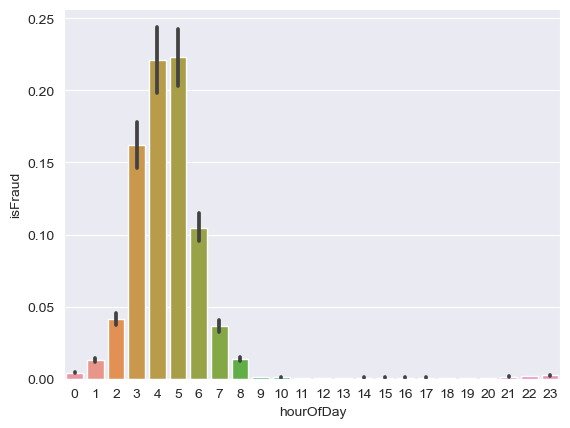

In [139]:
sns.barplot(x='hourOfDay', y='isFraud', data=df_augmented)

### Hypothesis 5: Fraud transactions will be correlated with the day of the week.

<Axes: xlabel='dayOfWeek', ylabel='isFraud'>

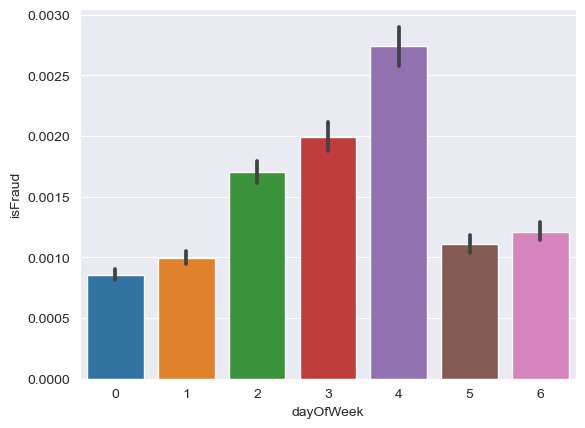

In [140]:
# Plot relation between 'dayOfWeek' and 'isFraud'
sns.barplot(x='dayOfWeek', y='isFraud', data=df_augmented)

### (Hypothesis 4, 5) In the above plots, we can see that:
- Fraud transactions are more likely to happen during the night (around 2:00 ~ 7:00)
- Fraud transactions are more likely to happen during 2, 3, 4 days of the week. (But we don't know which day of the week it is)

### Hypothesis 6: Consecutive 'TRANSFER' and 'CASH_OUT' transactions will have higher chance of being fraud.

In [141]:
for i in range(df_augmented.shape[0] - 1):
    isConsecutiveTransferCashOut = (df_augmented.loc[i, 'type'] == 'TRANSFER') & (df_augmented.loc[i + 1, 'type'] == 'CASH_OUT')
    # As seen in earlier exploration, the name of the consecutive transactions doesn't match, so we need to check it by amount.
    transactionAmountEquals = (df_augmented.loc[i, 'amount'] == df_augmented.loc[i + 1, 'amount']) 
    if isConsecutiveTransferCashOut and transactionAmountEquals:
        df_augmented.loc[i, 'isConsecutiveTransferCashOut'] = True
    else:
        df_augmented.loc[i, 'isConsecutiveTransferCashOut'] = False

<Axes: xlabel='isConsecutiveTransferCashOut', ylabel='isFraud'>

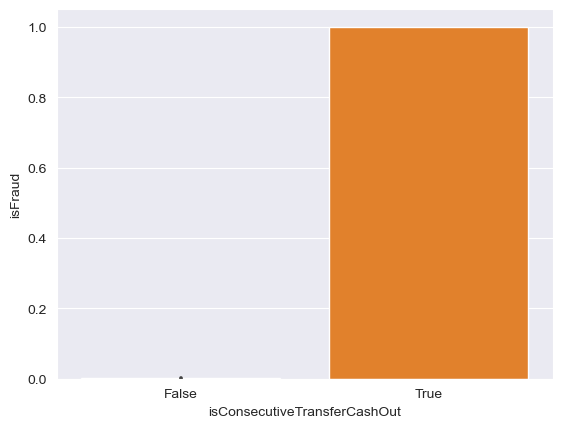

In [142]:
# Plot correlation between 'isConsecutiveTransferCashOut' and 'isFraud'
sns.barplot(x='isConsecutiveTransferCashOut', y='isFraud', data=df_augmented)

### (Hypothesis 6) In the above plot, we can see that:
- Consecutive 'TRANSFER' and 'CASH_OUT' transactions have a higher chance of being fraud.
- But, all fraud transactions are consecutive 'TRANSFER' and 'CASH_OUT' transactions??

Running out of assignment deadline :(